<a href="https://colab.research.google.com/github/AsyKhimki/Hello-GIT/blob/master/ptb_bidirectional_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bidirectional RNN for PTB dataset with LSTM unit

This notebook contains some RNN / LSTM networks for PTB dataset

**TODO**:
1. compare LSTM with GRU
2. create framework for hyperparameter tuning
3. add ROC curve ? 
4. use tensorboard with colab: https://medium.com/@kuanhoong/how-to-use-tensorboard-with-google-colab-43f7cf061fe4

**Long term**
1. How to freeze weights ? (i.e. do transfer learning)

**Userful links**
1. Hyperparameter tuning frameworks https://medium.com/@mikkokotila/a-comprehensive-list-of-hyperparameter-optimization-tuning-solutions-88e067f19d9


**Define models in separate .py files**
**NB:** Flag - use pre-trained
Resnet - similiar to baseline

Put Binaries -> 
Hyperparameter search
Ensemble Notebook
**Q** difference between notebook report and final report?

Rules:
Time complexity
You do not want bottleneck
Saptial dimension reduction 
Increase fil
Rule of thumbs cnn

Summarize
1. Edit LSTM notebooks
2. Transfer learning
3. Generate environment

**Q**: Have they already done data preprocessing from the paper?

In [0]:
import pandas as pd
import numpy as np

from keras import Sequential, Model
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Flatten, Lambda


from keras.layers import Conv1D, Convolution1D, Convolution2D, MaxPool1D, MaxPooling2D, GlobalMaxPool1D, AveragePooling1D, GlobalAveragePooling1D
from keras.layers import concatenate, Bidirectional, LSTM, GRU


from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split


Load the data (can I do it from my local computer?)

In [3]:
# run if data on google drive in folder ETH_ML4H/heartbeat
# TODO: change folder name
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/ETH_ML4H/input

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/ETH_ML4H/input


### Prepare data for training / testing

In [4]:
df_1 = pd.read_csv("ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])


Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]


#print("") # 
X.shape[1]

187

In [0]:
#X.shape[0]

Normalize data

**Q**  what other preprocessing techniques are used for ECG data preprocessing?

from *Mostayed, Ahmed, et al. "Classification of 12-lead ECG signals with Bi-directional LSTM network."*:

1. QRS detection of ECG signal
2. We used a Butterworth high-pass filter with cut-off frequency 1 Hz to remove the baseline wander. 
3. High frequency noise was removed using wavelet transform-based shrinkage methods [16].

In [0]:
# normalize without taking the zero-padding at the end into account:
timepoints_per_sample = X.shape[1]

for sample_idx in range(X.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X[sample_idx, 0: first_zero_sample, 0] -= np.mean(X[sample_idx, 0: first_zero_sample, 0])
    X[sample_idx, 0: first_zero_sample, 0] /= np.std(X[sample_idx, 0: first_zero_sample, 0])


for sample_idx in range(X_test.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X_test[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X_test[sample_idx, 0: first_zero_sample, 0] -= np.mean(X_test[sample_idx, 0: first_zero_sample, 0])
    X_test[sample_idx, 0: first_zero_sample, 0] /= np.std(X_test[sample_idx, 0: first_zero_sample, 0])

### **Wavelet transform**
Try to use continuous wavelet transform for the input

In [0]:
#!setup.py install pywt
import pywt

In [27]:
# coef.shape
# X.shape

(11641, 187, 1)

In [0]:
#TODO: how do I select scales?
#Source: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

wavelet_temp = 'morl'
max_scale_temp = 15
scales_temp = np.arange(1,max_scale_temp)

ctw_X, _ = pywt.cwt(X, scales=scales_temp, wavelet=wavelet_temp)
ctw_X_test, _ =  pywt.cwt(X_test, scales=scales_temp, wavelet=wavelet_temp)

In [9]:
#ctw_X.shape
# need to reshape it:
train_size = X.shape[0]
ctw_X_fin = np.ndarray(shape=(train_size, max_scale_temp-1, X.shape[1], 1))

for ii in range(0,train_size):
      coeff_ = ctw_X[:, ii,: , 0]
      ctw_X_fin[ii, :, :, 0] = coeff_

ctw_X_fin.shape
#X.shape

(11641, 14, 187, 1)

Try a simple model with wavelets:

In [0]:
def get_model_wavel():
    """

    @note:
        1. how do we select the number of lstm units and 
    """
    model = Sequential()
    model.add(Convolution2D(32, kernel_size=(2, 2), strides=(1, 1),
                    activation='relu',
                    input_shape=(max_scale_temp-1, 187,1) 
                    ))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Convolution2D(32, (2, 2), activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='softmax'))

    opt = optimizers.Adam(0.001)  # did changing the lr help ? 

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [13]:
model_wavel = get_model_wavel( ) # m_timepoints_per_sample=187, internal_dim=20

file_path = "bidirect_wavel_ptbdb.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early


model_wavel.fit(ctw_X_fin, Y, epochs=50,  batch_size = 400, verbose=2, callbacks=callbacks_list, validation_split=0.1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 13, 186, 32)       160       
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 186, 32)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 93, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 92, 32)         4128      
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 92, 32)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 46, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2944)             

In [20]:
coef.shape

(7, 2911, 187, 1)

# **RNN models**

Define a toy bidirectional lstm model

**TODO:** study all layers / loss functions / optimization

**Questions**
1. How to add a skip connection ?

In [0]:
def get_model_lstm():
    """

    @note:
        1. how do we select the number of lstm units and 
    """
    model = Sequential([
      Bidirectional(LSTM(64), input_shape=(187,1)),
      Dropout(0.5, name='dropout'),
      Dense(32, activation="relu"),
      Dense(1, activation="sigmoid")
    ])

    opt = optimizers.Adam(0.001)  # did changing the lr help ? 

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

Train the model

In [0]:
#model = get_model( m_timepoints_per_sample=187 )





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidir1 (Bidirectional)       (None, 187, 80)           13440     
_________________________________________________________________
dropout (Dropout)            (None, 187, 80)           0         
_________________________________________________________________
dense1 (Dense)               (None, 187, 40)           3240      
_________________________________________________________________
flatten_1 (Flatten)          (None, 7480)              0         
_________________________________________________________________
dense2 (Dense)               (None, 1)                 7481      
Total params: 24,161
Trainable params

In [0]:
model = get_model_lstm( ) # m_timepoints_per_sample=187, internal_dim=20

file_path = "bidirect_test_ptbdb.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early


model.fit(X, Y, epochs=50,  batch_size = 400, verbose=2, callbacks=callbacks_list, validation_split=0.1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               33792     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 37,953
Trainable params: 37,953
Non-trainable params: 0
_________________________________________________________________
Train on 10476 samples, validate on 1165 samples
Epoch 1/50
 - 29s - loss: 0.6136 - acc: 0.7027 - val_loss: 0.5635 - val_acc: 0.6996

Epoch 00001: val_acc improved from -inf to 0.69957, saving model to bidirect_test_ptbdb.h5
Epoch 2/50
 - 26s - loss: 0.4916 - acc: 0.7324 - val_loss: 0.4531 - val_acc: 0.7468

Epoch 00002: val_acc improved from 0.69957 to 0.74678, saving model to

Getting output from intermediate layers for TSNE and UMAP

In [0]:
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

f1 = f1_score(Y_test, pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.9479961832061069 
Test accuracy score : 0.925111645482652 


## Plotting

### TSNE based on latent representation

In [0]:
from keras import backend as K

# with a Sequential model
# Q: is it the third layer?
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])

layer_output = get_3rd_layer_output([X])[0]

In [0]:
layer_output.shape

(11641, 32)

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

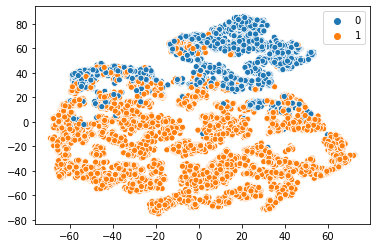

In [0]:
#layer_output
# Q what is 10
X_plot_test = TSNE(n_components=2, perplexity=50, random_state=1337).fit_transform(layer_output)
sns.scatterplot(x=X_plot_test[:,0], y=X_plot_test[:,1], hue=Y)
plt.show()

### Plot ROC curve to compare various keras classifiers

see https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

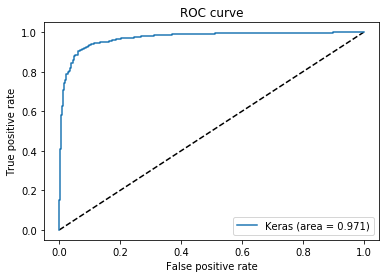

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


#from keras.wrappers.scikit_learn import KerasClassifier
#keras_model = build_model()
#keras_model.fit(X_train, y_train, epochs=5, batch_size=100, verbose=1)


y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# GRU model

In [0]:
def get_model_GRU():
    model = Sequential([
      Bidirectional(GRU(64), input_shape=(187,1)),
      Dropout(0.5, name='dropout'),
      Dense(32, activation="relu"),
      Dense(1, activation="sigmoid")
    ])

    opt = optimizers.Adam(0.001)  # did changing the lr help ? 

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [16]:
model_gru = get_model_GRU( ) # m_timepoints_per_sample=187, internal_dim=20

file_path = "bidirect_gru_ptbdb.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early


model_gru.fit(X, Y, epochs=50,  batch_size = 400, verbose=2, callbacks=callbacks_list, validation_split=0.1)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               25344     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 29,505
Trainable params: 29,505
Non-trainable params: 0
_________________________________________________________________



Train on 10476 samples, valida

In [18]:
model_gru.load_weights(file_path)

pred_test = model_gru.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

f1 = f1_score(Y_test, pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.9127674582647544 
Test accuracy score : 0.872552387495706 


##  Bi-directional LSTM Network

(from Mostayed, Ahmed, et al. "Classification of 12-lead ECG signals with Bi-directional LSTM network.")


**NB:** they have used 100 LSTM units

In [0]:
def get_model_bidir_lstm():
    model = Sequential([
      Bidirectional(LSTM(64, return_sequences=True), input_shape=(187,1)),
      Dropout(0.5, name='dropout1'),
      Bidirectional(LSTM(64, return_sequences=False)),
      Dropout(0.5, name='dropout2'),
      #Dense(32, activation="relu"),
      Dense(1, activation="sigmoid")
    ])

    opt = optimizers.Adam(0.001)  # did changing the lr help ? 

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model


In [7]:
model_bidir_lstm = get_model_bidir_lstm( ) # m_timepoints_per_sample=187, internal_dim=20

file_path = "bidirect_bidir_lstm_ptbdb.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early


model_bidir_lstm.fit(X, Y, epochs=50,  batch_size = 400, verbose=2, callbacks=callbacks_list, validation_split=0.1)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 187, 128)          33792     
_________________________________________________________________
dropout1 (Dropout)           (None, 187, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout2 (Dropout)           (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 132,737
Trainable param

In [9]:
model_bidir_lstm.load_weights(file_path)

pred_test = model_bidir_lstm.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

f1 = f1_score(Y_test, pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.9460819554277499 
Test accuracy score : 0.9227069735486088 


# **Temporal Convolutional Network (TCN)**
 
 **Q** why is it different from just stacking convolutional layers until the final output is of the right size?

 Defining some constants:

In [6]:
timepoints_per_sample = X.shape[1]

(11641, 187, 1)

In [0]:
def get_model_tcn( timesteps=timepoints_per_sample, input_dim=1):
    """
    @note:  I AM NOT SURE IT CORRECTLY REFLETS THE TCN ARCHITECTURE
    """
    # Input layer
    i = Input(batch_shape=(None, timesteps, input_dim))
    # Try to do TCN
    # Ok I do a dilated convolution instead 
    # Hopefully I understant it correctly
    o = Conv1D(filters=1, kernel_size=2, 
               padding='causal', 
               dilation_rate=2,
               activation="relu", name="dilated_conv")(i)  # The TCN layers are here.
    # Output classification layer
    #o = Dense(1, activation="sigmoid", name="dense_out")(o)

    model = Model(inputs=[i], outputs=[o])
    model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=['acc'])

    model.summary()
    return model

In [36]:
model_tcn = get_model_tcn( ) # m_timepoints_per_sample=187, internal_dim=20

file_path = "ptbdb_tcn.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early


model_tcn.fit(X, Y, epochs=50,  batch_size = 400, verbose=2, callbacks=callbacks_list, validation_split=0.1)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 187, 1)            0         
_________________________________________________________________
dilated_conv (Conv1D)        (None, 187, 1)            3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


ValueError: ignored